In [1]:
import csv
import slabeventclassify as evc
import matplotlib.pyplot as plt
import numpy as np
import circ

In [77]:
def get_GeoNetevents(szone):
    with open('../5BeachBallsMap/GeoNet_slabevents.csv', 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        slat,slon,sdep,sMw,s1,d1,r1,s2,d2,r2 = [],[],[],[],[],[],[],[],[],[]
        hik_count, puy_count = 0,0
        # 'lon,lat,dep,Mw,strike1,dip1,rake1,strike2,dip2,rake2'
        for row in csvreader:
            if float(row[2])>300:
                continue
            if float(row[2])<=10:
                continue
            if evc.within_interfacezone(float(row[0]), float(row[1]))==szone:
                slat.append(float(row[1]))
                slon.append(float(row[0]))
                sdep.append(float(row[2]))
                sMw.append(float(row[3]))
                s1.append(float(row[4]))
                d1.append(float(row[5]))
                r1.append(float(row[6]))
                s2.append(float(row[7]))
                d2.append(float(row[8]))
                r2.append(float(row[9]))
    dump = {'lon': slon,'lat': slat, 'dep': sdep, 
            'Mw':sMw, 'strike1': s1, 'dip1': d1,'rake1':r1,
            'strike2':s2, 'dip2':d2, 'rake2': r2,}
    return dump


def cbinning(data_angles,binsize = 10, maxangle = 360):
    # circular count is needed. 
    # binsize must be an integer
    halfbinw = int(binsize/2)
    cbins = [x for x in range(halfbinw,maxangle,halfbinw)]
    bin_count = [0]*len(cbins)
    for cb, i in zip(cbins, range(len(bin_count))):
        lowangle = cb-halfbinw 
        highangle = cb+halfbinw
        for sang in data_angles:
            if sang== highangle:
                sang = lowangle
            if (sang>= lowangle) & (sang<highangle):
                bin_count[i]=bin_count[i]+1

    return cbins, bin_count

def plot_hist(data_angles, ax, stitle ='', facecolor='c'):
    theta, freq = cbinning(data_angles)
    circ.histogram(theta, freq, bs = 2, units="degrees", \
               bars = True, normalized = False, lcolor="k", \
               lwidth = 0.5, facecolor = facecolor, axe = ax)
    ax.set_title(stitle)

    
def binned_boxes(x, y, fbs =10, min_x = 20, max_x = 300, doplot=True,
                        strtitle='', xlabel='depth (km)', ylabel = '', circular_data = False):
    # plot y according to binnned x
    x_bin = [d for d in range(min_x, max_x, fbs)]
    xbox  ={}
    
    for xb in x_bin:
        kx =[]
        for xx, yy in zip(x, y):
            if (xx>=(xb-fbs)) & (xx<(xb+fbs)):
                kx.append(yy)
        
        xbox.update({xb:kx})
    data = []
    for b in xbox.keys():
        data.append(xbox[b])
    if doplot:
        fig = plt.figure(1, figsize=(17,2))
        X = range(1, len(x_bin)+1)
        plt.rcParams.update({'font.size': 13})
        if circular_data:
            circ_boxplot(data);
        else:
            plt.boxplot(data)
        #for dat,x in zip(data,X):
        #  plt.text(x,70, str(len(dat)))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks([x for x in X],
           [str(xx) for xx in x_bin]);
        plt.title(strtitle, fontsize=13)
    
    return xbox

# set aside for time being
def circ_boxplot(data, high=360):
    rdata = []
    for dat in data:
        dat = np.array(dat)
        qr = np.percentile(dat, [25, 50, 75])
        iqr = qr[2]-qr[0]
        ub = qr[2]+(1.5*iqr)
        lb = qr[0]-(1.5*iqr)
        
        upper_bound = ub + 3*(ub-qr[2])
        lower_bound = lb - 3*(qr[0]-lb)
        outs = dat[(dat <= lower_bound) | (dat >= upper_bound)]
        nouts = dat[(dat > lower_bound) & (dat < upper_bound)]
        nouts = nouts.tolist()
        for x in outs:
            if x>=upper_bound:
                nouts.append(x-high)
            else:
                nouts.append(x+high)
        
        rdata.append(nouts)
        
    plt.boxplot(rdata)

In [74]:
dump_hik = get_GeoNetevents('hik')
dump_puy = get_GeoNetevents('puy')
slabevents = {'hik': dump_hik, 'puy': dump_puy}

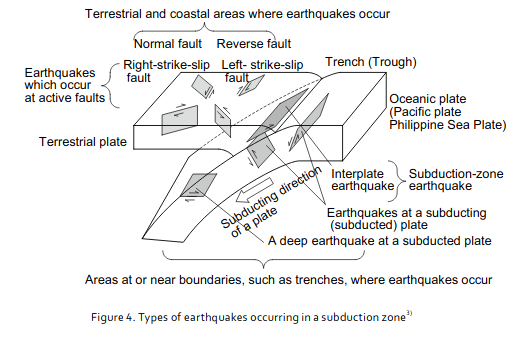

https://www.jaso.jp/pdf/earthquake_resistant.pdf

In [61]:
# we make choice
def process_strikediprake(slabevents, szone):
    finterp_file = {'hik': '../1SubductionModel/hik_finterp.npy', 
                'puy': '../1SubductionModel/puy_finterp.npy',}
    
    finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
    strike_finterp = finterp['strikeAn']
    dip_finterp = finterp['dipAn']
    
    lon, lat = slabevents[szone]['lon'], slabevents[szone]['lat']
    strike1, strike2 = slabevents[szone]['strike1'], slabevents[szone]['strike2']
    dip1, dip2  = slabevents[szone]['dip1'], slabevents[szone]['dip2'] 
    rake1, rake2  = slabevents[szone]['rake1'], slabevents[szone]['rake2'] 
    
    deps = slabevents[szone]['dep']
    mystrike, slabstrike = [], []
    myrake = []
    mydip, slabdip, mydep = [],[],[]
    
    critical_dip = {'hik': 30, 'puy': 60}
    
    for x,y,s1,s2,d1,d2,r1,r2,dep in zip(lon,lat,strike1,strike2,dip1,dip2,rake1,rake2,deps):
        #
        kslabstrike = strike_finterp(np.transpose([[x],[y]]))
        kslabdip = dip_finterp(np.transpose([[x],[y]]))
        
        if kslabdip>critical_dip[szone]:
            if szone=='hik':
                kstrike = kslabstrike-180
            else:
                kstrike = kslabstrike-180
        else:
            kstrike = kslabstrike
        
        lowstrike, highstrike = kstrike-90, kstrike+90
        
        if lowstrike <0:
            lowstrike = 360+lowstrike
        if highstrike>360:
            highstrike = highstrike-360 
            
        if lowstrike>highstrike:
            if (s1>= lowstrike) | (s1<=highstrike):
                mystrike.append(s1)
                mydip.append(d1)
                myrake.append(r1)
                mydep.append(dep)
            else:
                mystrike.append(s2)
                mydip.append(d2)
                myrake.append(r2)
                mydep.append(dep)
        else:    
            if (s1>= lowstrike) & (s1<=highstrike):
                mystrike.append(s1)
                mydip.append(d1)
                myrake.append(r1)
                mydep.append(dep)
            else:
                mystrike.append(s2)
                mydip.append(d2)
                myrake.append(r2)
                mydep.append(dep)
        slabstrike.append(kslabstrike)
        slabdip.append(kslabdip)
        
    return {'strike': mystrike, 'dip': mydip, 'rake': myrake, 'dep': mydep,
            'slabstrike': slabstrike, 'slabdip': slabdip,} 


In [62]:
dump_hik = process_strikediprake(slabevents, 'hik')
dump_puy = process_strikediprake(slabevents, 'puy')

procslabevents  = {'hik': dump_hik, 'puy': dump_puy,}

In [63]:
def quick_assess(szone, xslabevents):
    stitle = {'hik': 'Hikurangi Slab', 'puy': 'Puysegur slab'}
    fig = plt.figure(1, figsize=(5,5))
    ax1 = fig.add_subplot(111, projection='polar')  
    plot_hist(xslabevents[szone]['strike'], ax=ax1, stitle ='strike angles', facecolor='c')
    fig.suptitle(stitle[szone], fontsize=14, y=0.71)  
    fig.tight_layout()
    plt.show()
    if szone=='puy':
        binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['strike'], strtitle='', 
                 ylabel='strike (deg)');
    else:
        binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['strike'], strtitle='', 
                 ylabel='strike (deg)', circular_data = True);
    
    plt.show()
    binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['dip'], strtitle='', ylabel='dip (deg)');
    plt.show()
    binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['rake'], strtitle='', ylabel='rake (deg)');
   

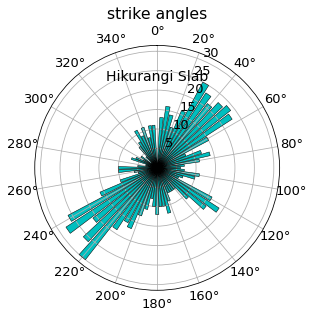

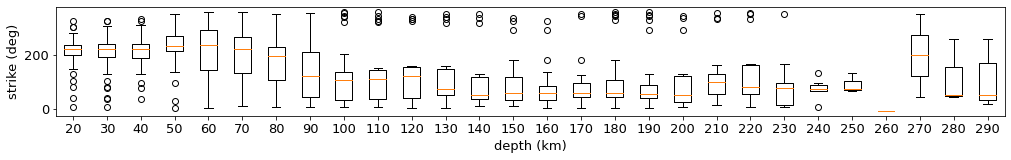

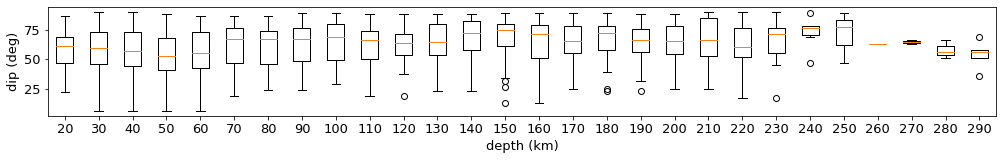

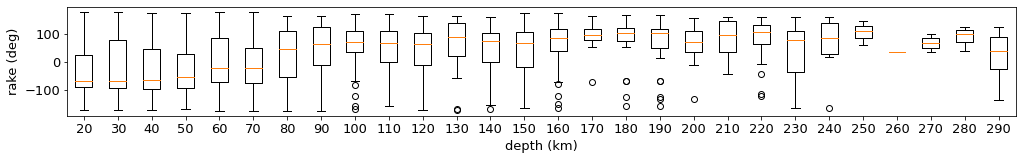

In [68]:
quick_assess('hik', procslabevents)

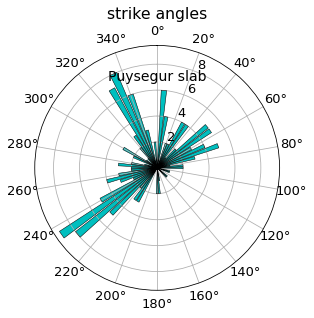

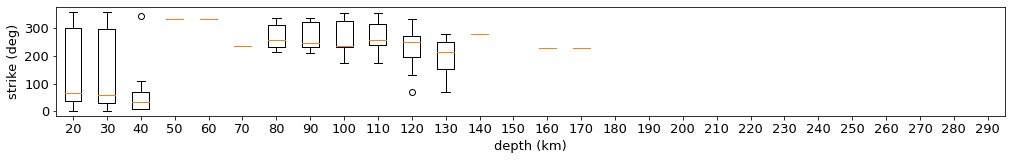

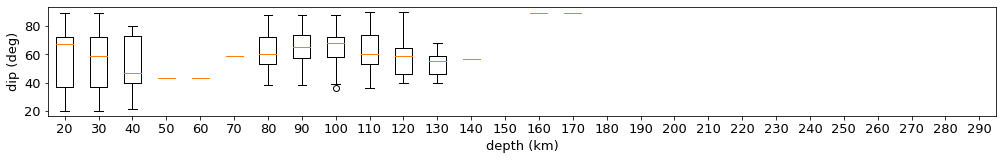

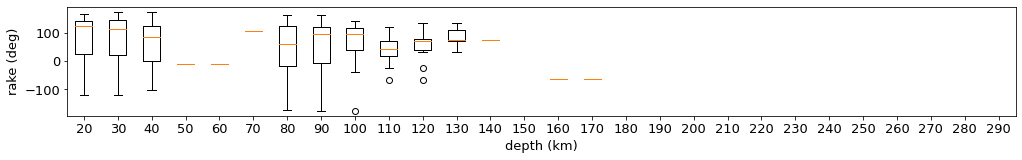

In [50]:
quick_assess('puy', procslabevents)

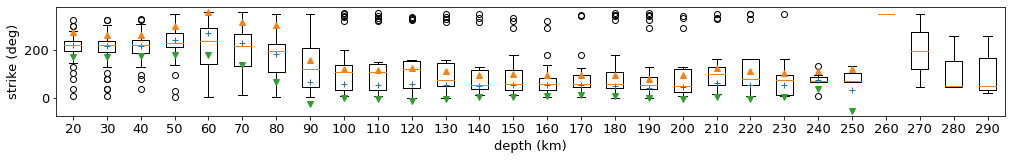

In [79]:
import circ
szone = 'hik'
boxstrike = binned_boxes(procslabevents[szone]['dep'], 
                         procslabevents[szone]['strike'], doplot=False);
X, means,lower_stds, upper_stds = [],[],[],[]
for db in boxstrike.keys():
    data = boxstrike[db]
    if len(data)<5:
        continue
    mens = circ.meanstats(data, high =360, low = 0, bound=False)
    means.append(mens[1])
    lower_stds.append(mens[0])
    upper_stds.append(mens[2])
    X.append(db)


sY = []
for x,y in zip(X,stds):
    sY.append(x+y)

    
binned_boxes(procslabevents[szone]['dep'], 
                        procslabevents[szone]['strike'], strtitle='', ylabel='strike (deg)');
plt.plot(range(1,len(X)+1),means, '+')
plt.plot(range(1,len(X)+1),upper_stds, '^')
plt.plot(range(1,len(X)+1),lower_stds, 'v')
